In [1]:
from access import Access, weights, Datasets

import logging
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## Example Data Sets
The `Datasets` class provides a number of datasets that are used in this and other examples showing how to use the `Access` package. You can see the available datasets by running the following command.

In [2]:
Datasets.available_datasets()  # will update the output of this to be more descriptive rather than just the file names


chi_times: Cost matrix with travel times from each Chicago Census Tract to all others.

chi_doc: Doctor and dentist counts for each Chicago Census Tract.

chi_pop: Population counts for each Chicago Census Tract.

chi_doc_geom: Doctor and dentist counts for each Chicago Census Tract along with geometric representations for Census Tracts.

chi_pop_geom: Population counts for each Chicago Census Tract along with geometric representations for Census Tracts.

chi_euclidean: Euclidean distance cost matrix with distances from each demand Chicago Census Tract to all others.

chi_euclidean_neighbors: Euclidean distance cost matrix with distances from each supply Census Tract to all others.

cook_county_hospitals: Contains data for each hospital location in Cook County including X Y coordinates.

cook_county_hospitals_geom: Contains data for each hospital location in Cook County including X Y coordinates, and geometric points for each hospital.

cook_county_tracts: Geometric representation of 

For this exercise, we'll need three datasets to instantiate an instance of `Access`:
- demand dataset (chi_pop_geom)
- supply dataset (chi_doc_geom)
- cost matrix (chi_times)

**NOTE:** In this example, we'll be using the `_geom` variants so that we can calculate euclidean distances between points and use euclidean distance as a cost metric. If you have already have a cost matrix, you won't need the geometric data.

### Load Supply and Demand Data
Each of the datasets shown below show population and doctor/dentist counts, respectively, at the Census Tract level for all Census Tracts in and within and 50km of Chicago's boundaries.

In [3]:
chi_pop = Datasets.load_data("chi_pop_geom")
chi_doc = Datasets.load_data("chi_doc_geom")

In [4]:
chi_pop.head()

,geoid,pop,geometry
0,17031010100,4854,POINT (354916.992 594670.505)
1,17031010201,6450,POINT (354105.876 594088.600)
2,17031010202,2818,POINT (354650.684 594093.822)
3,17031010300,6236,POINT (355209.361 594086.149)
4,17031010400,5042,POINT (355809.748 592808.043)


In [5]:
chi_doc.head()

,geoid,doc,dentist,geometry
0,17031010100,1,1,POINT (354916.992 594670.505)
1,17031010201,0,1,POINT (354105.876 594088.600)
2,17031010202,4,1,POINT (354650.684 594093.822)
3,17031010300,4,1,POINT (355209.361 594086.149)
4,17031010400,0,2,POINT (355809.748 592808.043)


### Loading Network Distance Data

The chi_times contains geoid fields for the origin and destination tracts and a cost field (number of minutes it takes to travel from origin to destination). See the [main site's cost matrix section](https://access.readthedocs.io/en/latest/resources.html) for hints on downloading lots of travel times like this. 

In [7]:
chi_times = Datasets.load_data("chi_times")

In [8]:
chi_times.head()

,origin,dest,cost
0,17093890101,17031010100,91.20
1,17093890101,17031010201,92.82
2,17093890101,17031010202,92.95
3,17093890101,17031010300,89.40
4,17093890101,17031010400,84.97


## Create the `access` Object

Since we have geometries here, it could be as simple as this:

In [9]:
A = Access(
    demand_df=chi_pop,
    demand_index="geoid",
    demand_value="pop",
    supply_df=chi_doc,
    supply_index="geoid",
    supply_value=["doc", "dentist"],
    cost_df=chi_times,
    cost_origin="origin",
    cost_dest="dest",
    cost_name="cost",
    neighbor_cost_df=chi_times,
    neighbor_cost_origin="origin",
    neighbor_cost_dest="dest",
    neighbor_cost_name="cost",
)

### Add an Additional Distance Measure - Euclidean Distance

Though we've already loaded a network distance matrix, we can still add a Euclidean distance matrix. This requires geopandas to be installed, and you should already have projected the data. In case you have not, below we show how to see your current projection, and how to change it to the correct one (if you don't know what projection to use, you can reference the [spatial reference](https://spatialreference.org/) website).

In [18]:
print(A.demand_df.crs)
print(A.supply_df.crs)

epsg:2790
epsg:2790


In [19]:
A.demand_df = A.demand_df.to_crs(epsg=3528)
A.supply_df = A.supply_df.to_crs(epsg=3528)

Now we'll calculate the Euclidean distance matrix. Note that this is a very costly operation, but you only have to do it once.  `threshold` is the maximum distance (km) that we will consider. Calculating distances between centroids takes a while but is still faster than computing distances to polygons (crazy expensive, though we've been moderately careful to make it faster).

In [21]:
A.create_euclidean_distance(threshold=250000, centroid_o=True, centroid_d=True)

Calling `A.cost_df` will now show the 'eulidean' column in the cost dataframe.

In [22]:
A.cost_df

,origin,dest,cost,euclidean
0,17093890101,17031010100,91.20,63630.788476
1,17093890101,17031010201,92.82,62632.675522
2,17093890101,17031010202,92.95,63073.735631
3,17093890101,17031010300,89.40,63520.029749
4,17093890101,17031010400,84.97,63268.514352
...,...,...,...,...
4284625,17197980100,17111870809,NaN,80097.128392
4284626,17197980100,17111871310,NaN,67358.028756
4284627,17197980100,17197880308,NaN,11161.067033
4284628,17197980100,17197881007,NaN,14547.843032


### Create Some Weight Functions

Of course, you don't _have_ to do this, but it's fun to play with different versions of spatial access, esp. E2SFCA. You can create the weighting functionsfrom stepwise weight dictionaries.

In [23]:
fn30 = weights.step_fn({10: 1, 20: 0.68, 30: 0.22})
fn60 = weights.step_fn({20: 1, 40: 0.68, 60: 0.22})

Or, you can use gaussian weights.  Here, we're using a value of 20 (minutes), such that we'll be at the 3σ level at 60 minutes.

This could also be done through scipy.stats.norm().pdf, but that turns out to be unacceptably slow.

In [24]:
gaussian = weights.gaussian(20)

Lastly, you could use a conventional gravity model, which is just weighted catchment with gravity weighting.

In [25]:
gravity = weights.gravity(scale=60, alpha=-1)

## Ready to roll...

Now just call the access functions. Each of these will return the corresponding series, but they are also stored in `A.access_df`.  Check out the documentation for the possible arguments. Note that if you call the same function repeatedly, with different arguments, you may want to change the name, to avoid overwriting. By default, `access` will calculate access metrics for each of the supply columns unless you specify a particular subset.

In [26]:
A.weighted_catchment(name="gravity", weight_fn=gravity)
A.fca_ratio(name="fca", max_cost=15)
A.fca_ratio(name="fca", max_cost=30)  # Note - the warning -- good!
A.fca_ratio(name="fca60", max_cost=60)
A.fca_ratio(name="fca90", max_cost=90)
A.two_stage_fca(name="2sfca", max_cost=60)
A.enhanced_two_stage_fca(name="2sfca30", weight_fn=fn30)
A.enhanced_two_stage_fca(name="2sfca60", weight_fn=fn60)
A.enhanced_two_stage_fca(name="g2sfca", weight_fn=gaussian)
A.three_stage_fca(name="3sfca")

A.raam(name="raam", tau=60)
A.raam(name="raam30", tau=30);

access INFO     :: Using default cost, cost, for gravity.
access INFO     :: Using default cost, cost, for fca.
access INFO     :: Using default neighbor cost, cost, for fca.
access INFO     :: Using default cost, cost, for fca.
access INFO     :: Using default neighbor cost, cost, for fca.
access INFO     :: Overwriting fca_doc.
access INFO     :: Overwriting fca_dentist.
access INFO     :: Using default cost, cost, for fca60.
access INFO     :: Using default neighbor cost, cost, for fca60.
access INFO     :: Using default cost, cost, for fca90.
access INFO     :: Using default neighbor cost, cost, for fca90.
access INFO     :: Using default cost, cost, for 2sfca.
access INFO     :: Using default cost, cost, for 2sfca30.
access INFO     :: Using default cost, cost, for 2sfca60.
access INFO     :: Using default cost, cost, for g2sfca.
access INFO     :: Using default cost, cost, for 3sfca.
access INFO     :: Using default cost, cost, for raam.
access INFO     :: Using default cost, cos

In [27]:
A.access_df.sort_values(by="raam_doc").dropna().head()

,pop,gravity_doc,gravity_dentist,fca_doc,fca_dentist,fca60_doc,fca60_dentist,fca90_doc,fca90_dentist,2sfca_doc,...,2sfca60_doc,2sfca60_dentist,g2sfca_doc,g2sfca_dentist,3sfca_doc,3sfca_dentist,raam_doc,raam_dentist,raam30_doc,raam30_dentist
geoid,,,,,,,,,,,,,,,,,,,,,
17031808800,3955,48874.111283,7990.336879,0.001049,0.000878,0.001100,0.000667,0.000912,0.000620,0.000760,...,0.000650,0.000431,0.000700,0.000433,0.001666,0.000963,0.610053,0.842621,0.518374,0.869783
17031809300,4816,14613.314584,6731.779891,0.001082,0.000821,0.001174,0.000694,0.000925,0.000623,0.000690,...,0.000635,0.000401,0.000683,0.000415,0.001695,0.000965,0.654022,0.897259,0.605593,0.961986
17031806801,4225,17700.521096,10206.437126,0.001036,0.000936,0.000988,0.000650,0.000901,0.000617,0.000930,...,0.001029,0.000678,0.001045,0.000704,0.001378,0.001067,0.676216,0.751016,0.588885,0.615765
17031809100,3387,10512.460373,6840.560712,0.001109,0.000886,0.001059,0.000664,0.000906,0.000617,0.000845,...,0.000805,0.000515,0.000829,0.000528,0.001654,0.000950,0.701590,0.893923,0.690675,0.924893
17031808702,5504,23763.514763,8244.668327,0.001106,0.000779,0.001179,0.000691,0.000928,0.000624,0.000650,...,0.000626,0.000387,0.000645,0.000383,0.001687,0.000912,0.703447,0.932076,0.686627,0.956822


These were all with network travel time, in minutes.  We could also run the calculation with Euclidean distance.  Note that the parameters for the access fucntion will be dramatically different in meters instead of minutes!  Here, RAAM's tau parameter shifts from 60 minutes to 100 km (1e5 meters).

In [28]:
raam = A.raam(name="raam_euclidean", tau=1e5, cost="euclidean")

raam.head()

,raam_euclidean_doc,raam_euclidean_dentist
geoid,,
17031010100,0.837117,0.881353
17031010201,0.836282,0.899506
17031010202,0.842233,0.878215
17031010300,0.859648,0.891032
17031010400,0.893507,0.883204


Gosh -- that's lots of access measures!  Let's simplify our life, with just one:

In [29]:
A.score(name="raam_combo", col_dict={"raam_doc": 0.8, "raam_dentist": 0.2})

geoid
17031010100    0.760373
17031010201    0.751101
17031010202    0.782341
17031010300    0.825140
17031010400    0.913720
                 ...   
17197883903    1.485736
17197883904    1.392151
17197884101    1.402404
17197884103    1.388448
17197980100    1.381479
Name: raam_combo, Length: 1930, dtype: float64

If there were only one cost function available, these logs wouldn't print.

If you found all the logs annoying instead of useful, then turn them off:

In [30]:
A.log.setLevel(logging.WARNING)

## Results time!

Let's get the correlations among measures, and plot a few of them...

In [31]:
A.norm_access_df.columns

Index(['2sfca30_dentist', '2sfca30_doc', '2sfca60_dentist', '2sfca60_doc',
       '2sfca_dentist', '2sfca_doc', '3sfca_dentist', '3sfca_doc',
       'fca60_dentist', 'fca60_doc', 'fca90_dentist', 'fca90_doc',
       'fca_dentist', 'fca_doc', 'g2sfca_dentist', 'g2sfca_doc',
       'gravity_dentist', 'gravity_doc', 'raam30_dentist', 'raam30_doc',
       'raam_combo', 'raam_dentist', 'raam_doc', 'raam_euclidean_dentist',
       'raam_euclidean_doc'],
      dtype='object')

In [32]:
A.norm_access_df.corr().raam_doc.abs().sort_values(ascending=False)

raam_doc                  1.000000
raam_combo                0.983396
raam30_doc                0.951257
raam_euclidean_doc        0.871828
3sfca_doc                 0.858268
fca_doc                   0.769326
2sfca30_doc               0.706941
gravity_doc               0.688615
g2sfca_doc                0.684157
gravity_dentist           0.658659
2sfca60_doc               0.653054
raam30_dentist            0.609425
g2sfca_dentist            0.591621
2sfca60_dentist           0.589258
raam_dentist              0.583213
2sfca_doc                 0.571955
fca_dentist               0.563269
2sfca_dentist             0.546611
2sfca30_dentist           0.512455
3sfca_dentist             0.486922
fca90_doc                 0.470519
raam_euclidean_dentist    0.377358
fca90_dentist             0.372606
fca60_doc                 0.316764
fca60_dentist             0.096010
Name: raam_doc, dtype: float64

In [33]:
il_map = chi_doc.set_index("geoid")[["geometry"]].join(A.norm_access_df, how="inner")


def plot(v, ax=None, leg=True):

    swap_colors = "raam" in v

    il_map.plot(
        v,
        legend=leg,
        figsize=(5, 5),
        cmap="viridis_r" if swap_colors else "viridis",
        markersize=5,
        alpha=0.8,
        ax=ax,
        vmin=il_map[v].quantile(0.05),
        vmax=il_map[v].quantile(0.95),
    ).set_axis_off()

Plotting RAAM for spatial access to doctors from Chicago tracts:

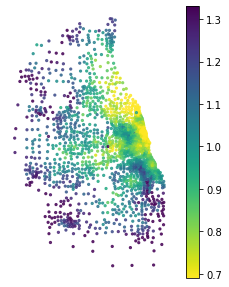

In [34]:
plot("raam_doc")

Plotting 3-Stage Floating Catchment Areas for for spatial access to dentists from Chicago tracts:

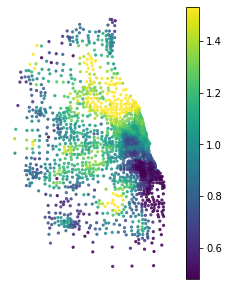

In [35]:
plot("3sfca_dentist")

Fascinating!  Is it true that the dentist shortage on Chicago's South Side is more acute than for doctors?  This would not be a total shock, since Medicare boosts demand for healthcare but not dental care in poor areas -- and since the University of Chicago Hospital is bigish.  Let's do the apples to apples comparison, with RAAM.

From left to right, maps of RAAM for doctors, dentists and both:

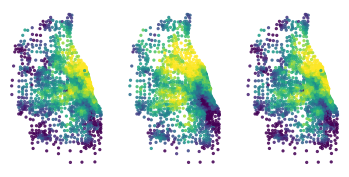

In [36]:
fig, ax = plt.subplots(1, 3, subplot_kw={"aspect": "equal"})
for axi in ax:
    axi.set_axis_off()

plot("raam_doc", ax=ax[0], leg=False)
plot("raam_dentist", ax=ax[1], leg=False)
plot("raam_combo", ax=ax[2], leg=False)

Seems to be the case...

Now you can save all model results to a csv file in your local directory.

In [37]:
A.norm_access_df.to_csv("results.csv")

Gravity works too (here for doctors).  Not really appropriate in this case, since there is fixed supply.

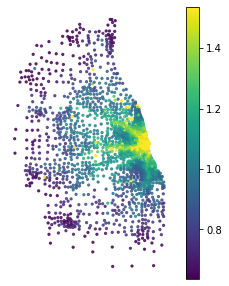

In [38]:
plot("gravity_doc")